# Libraries Importing

*Use GPU, as some graphs will not show without it*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install bertopic

In [3]:
import pandas as pd
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import PartOfSpeech, MaximalMarginalRelevance
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.model_selection import ParameterGrid
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Loading the Data Set

In [4]:
DATA_SET_PATH = "/content/drive/MyDrive/Chatgpt.csv"
df = pd.read_csv(DATA_SET_PATH)

In [5]:
df

,Datetime,Tweet Id,Text,Username,Permalink,User,Outlinks,CountLinks,ReplyCount,RetweetCount,LikeCount,QuoteCount,ConversationId,Language,Source,Media,QuotedTweet,MentionedUsers,hashtag,hastag_counts
0,2023-01-22 13:44:34+00:00,1617156270871699456,ChatGPTで遊ぶの忘れてた！！\n書類作るコード書いてみてほしいのと、\nどこまで思考整...,mochico0123,https://twitter.com/mochico0123/status/1617156...,https://twitter.com/mochico0123,NaN,NaN,1,0,5,0,1617156270871699456,ja,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,[],0
1,2023-01-22 13:44:39+00:00,1617156291046133761,@AlexandrovnaIng Prohibition of ChatGPT has be...,Caput_LupinumSG,https://twitter.com/Caput_LupinumSG/status/161...,https://twitter.com/Caput_LupinumSG,NaN,NaN,1,0,5,0,1617148639993806848,en,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,"[User(username='AlexandrovnaIng', id=282705900...",[],0
2,2023-01-22 13:44:44+00:00,1617156308926349312,"Schaut Euch an, was @fobizz @DianaKnodel alles...",ciffi,https://twitter.com/ciffi/status/1617156308926...,https://twitter.com/ciffi,['https://us02web.zoom.us/webinar/register/801...,"['https://t.co/DsoeVJrPBp', 'https://t.co/HflT...",0,0,4,0,1617156308926349312,de,"<a href=""http://twitter.com/#!/download/ipad"" ...",[Photo(previewUrl='https://pbs.twimg.com/media...,https://twitter.com/DianaKnodel/status/1617153...,"[User(username='fobizz', id=884708145792253952...",['#ChatGPT'],1
3,2023-01-22 13:44:49+00:00,1617156332297256961,Bow down to chatGPT 🫡..... https://t.co/ENTSzi...,Vishwasrisiri,https://twitter.com/Vishwasrisiri/status/16171...,https://twitter.com/Vishwasrisiri,['https://twitter.com/agadmator/status/1617155...,['https://t.co/ENTSzi2AQ9'],0,0,2,0,1617156332297256961,en,"<a href=""http://twitter.com/download/android"" ...",NaN,https://twitter.com/agadmator/status/161715501...,NaN,[],0
4,2023-01-22 13:44:52+00:00,1617156345064570880,"Profilinde vatan, Türkiye falan yazan bireyler...",0xGenetikciniz,https://twitter.com/0xGenetikciniz/status/1617...,https://twitter.com/0xGenetikciniz,NaN,NaN,0,0,4,0,1617156345064570880,tr,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,2023-01-24 06:57:56+00:00,1617778712082096128,"#ChatGPT ist ein #Chatbot, der durch künstlich...",HorstKrieger,https://twitter.com/HorstKrieger/status/161777...,https://twitter.com/HorstKrieger,"['https://lnkd.in/dzHbz5-z', 'https://lnkd.in/...","['https://t.co/qxUJZinuNO', 'https://t.co/lFZD...",0,0,0,0,1617778712082096128,de,"<a href=""http://www.linkedin.com/"" rel=""nofoll...",NaN,NaN,NaN,"['#ChatGPT', '#Chatbot,', '#KI', '#AI', '#Dial...",6
49997,2023-01-24 06:57:59+00:00,1617778726393249792,@r8r Ich hab mal die AI dazu befragt (ChatGPT)...,werpu,https://twitter.com/werpu/status/1617778726393...,https://twitter.com/werpu,NaN,NaN,0,0,0,0,1617774521586708480,de,"<a href=""https://mobile.twitter.com"" rel=""nofo...",[Photo(previewUrl='https://pbs.twimg.com/media...,NaN,"[User(username='r8r', id=15451529, displayname...",[],0
49998,2023-01-24 06:58:00+00:00,1617778728481992705,5 minuti di #chatGPT e ho capito che apprende ...,marcopiccinini,https://twitter.com/marcopiccinini/status/1617...,https://twitter.com/marcopiccinini,NaN,NaN,0,0,0,0,1617778728481992705,it,"<a href=""http://twitter.com/download/iphone"" r...",[Photo(previewUrl='https://pbs.twimg.com/media...,NaN,NaN,['#chatGPT'],1
49999,2023-01-24 06:58:01+00:00,1617778731678044162,Portland Shop Uses ChatGPT To Tell Family Stor...,EuniceNyandat,https://twitter.com/EuniceNyandat/status/16177...,https://twitter.com/EuniceNyandat,['https://drumup.io/s/DkswB6'],['https://t.co/rzGvr6yTOc'],0,0,0,0,1617778731678044162,en,"<a href=""https://drumup.io"" rel=""nofollow"">dru...",NaN,NaN,NaN,[],0


# Preprocessing

In [6]:
df_en_mask = df["Language"] == "en"
df_en = df[df_en_mask]
# Subset to 3,000 English tweets for performance and assignment requirements
df_en_subset = df_en.sample(n=3000, random_state=42).reset_index(drop=True)
tweets_en = df_en_subset["Text"]

In [7]:
df_en_subset

,Datetime,Tweet Id,Text,Username,Permalink,User,Outlinks,CountLinks,ReplyCount,RetweetCount,LikeCount,QuoteCount,ConversationId,Language,Source,Media,QuotedTweet,MentionedUsers,hashtag,hastag_counts
0,2023-01-22 21:37:59+00:00,1617275406230638593,i just know some weird ass life changing shift...,teaaaarex,https://twitter.com/teaaaarex/status/161727540...,https://twitter.com/teaaaarex,NaN,NaN,0,0,2,0,1617275406230638593,en,"<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,[],0
1,2023-01-23 13:32:41+00:00,1617515667309092865,@yabaleftonline Chat gpt lol,M3x762,https://twitter.com/M3x762/status/161751566730...,https://twitter.com/M3x762,NaN,NaN,0,0,1,0,1617483655789658114,en,"<a href=""http://twitter.com/download/android"" ...",NaN,NaN,"[User(username='yabaleftonline', id=769214965,...",[],0
2,2023-01-23 11:07:37+00:00,1617479158765916164,@filipamtg @LegacyEUTour I asked ChatGPT what ...,gnorilgrande,https://twitter.com/gnorilgrande/status/161747...,https://twitter.com/gnorilgrande,NaN,NaN,0,0,0,0,1617457256676597760,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,"[User(username='filipamtg', id=2732965535, dis...",[],0
3,2023-01-23 17:52:35+00:00,1617581072681664517,Probably you have a coder who can write any co...,santhoshkoyadan,https://twitter.com/santhoshkoyadan/status/161...,https://twitter.com/santhoshkoyadan,NaN,NaN,1,0,7,0,1617581072681664517,en,"<a href=""http://twitter.com/download/android"" ...",[Photo(previewUrl='https://pbs.twimg.com/media...,NaN,NaN,"['#stockselection', '#stockscreener', '#pinesc...",4
4,2023-01-22 16:45:25+00:00,1617201782203256833,This is a story about @edward_the6 and how he ...,amirsanroberto,https://twitter.com/amirsanroberto/status/1617...,https://twitter.com/amirsanroberto,NaN,NaN,1,0,1,0,1617201782203256833,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,"[User(username='edward_the6', id=4541083965, d...",['#ChatGPT'],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2023-01-23 15:51:59+00:00,1617550721129349121,Microsoft invests billions in ChatGPT firm Ope...,IBTimes,https://twitter.com/IBTimes/status/16175507211...,https://twitter.com/IBTimes,['https://www.ibtimes.com/microsoft-invests-bi...,['https://t.co/etPVPOyS1V'],0,0,0,0,1617550721129349121,en,"<a href=""https://www.echobox.com"" rel=""nofollo...",NaN,NaN,NaN,[],0
2996,2023-01-23 23:49:16+00:00,1617670833752903681,@SekouLRemy Going to come back to this because...,Dr_C_Taylor,https://twitter.com/Dr_C_Taylor/status/1617670...,https://twitter.com/Dr_C_Taylor,NaN,NaN,0,0,0,0,1617597396212383765,en,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,"[User(username='SekouLRemy', id=1093628184, di...",[],0
2997,2023-01-23 18:47:18+00:00,1617594844133871616,Curious about people's thoughts on ChatGPT!\n\...,GoFurtherAgency,https://twitter.com/GoFurtherAgency/status/161...,https://twitter.com/GoFurtherAgency,NaN,NaN,0,2,1,0,1617594844133871616,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,"['#ChatGPT', '#AI', '#Opinion']",3
2998,2023-01-23 20:25:37+00:00,1617619585091657728,#AI is a tool. Any consideration beyond that M...,Raptor2u,https://twitter.com/Raptor2u/status/1617619585...,https://twitter.com/Raptor2u,['https://www.dailymail.co.uk/news/article-116...,['https://t.co/HbQ3B942cN'],0,0,1,0,1617619585091657728,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,"['#AI', '#ChatGPT', '#chatbot', '#Wharton']",4


In [8]:
tweets_en

,Text
0,i just know some weird ass life changing shift...
1,@yabaleftonline Chat gpt lol
2,@filipamtg @LegacyEUTour I asked ChatGPT what ...
3,Probably you have a coder who can write any co...
4,This is a story about @edward_the6 and how he ...
...,...
2995,Microsoft invests billions in ChatGPT firm Ope...
2996,@SekouLRemy Going to come back to this because...
2997,Curious about people's thoughts on ChatGPT!\n\...
2998,#AI is a tool. Any consideration beyond that M...


In [9]:
!pip install emoji

In [10]:
def clean(tweet):
    import re
    import emoji
    cleaned = tweet.replace("#", "") # Remove hashtag symbols, but not the actual tags themselves as they may be useful for topic modeling
    cleaned = re.sub(r"@\S*", "", cleaned) # Remove mentions
    cleaned = emoji.replace_emoji(cleaned, replace='') # Remove emojis
    cleaned = re.sub(r"https?://\S+", "", cleaned) # Remove hyperlinks (at least those that start with "http")
    return cleaned

In [11]:
tweets_en_cleaned = tweets_en.apply(clean)

In [12]:
tweets_en_cleaned

,Text
0,i just know some weird ass life changing shift...
1,Chat gpt lol
2,I asked ChatGPT what to play in naples and h...
3,Probably you have a coder who can write any co...
4,This is a story about and how he has built GP...
...,...
2995,Microsoft invests billions in ChatGPT firm Ope...
2996,Going to come back to this because was having...
2997,Curious about people's thoughts on ChatGPT!\n\...
2998,AI is a tool. Any consideration beyond that MU...


No other preprocessing is performed because BERTopic requires the input to be left mostly unprocessed.

# Building the BERTopic Model

First, we precalculate document embeddings:

In [13]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(tweets_en_cleaned.to_numpy())

In [14]:
embeddings

array([[-0.11805789, -0.06587131,  0.1170012 , ..., -0.01251472,
        -0.01984593, -0.03326514],
       [-0.10399981, -0.05348641,  0.03676013, ...,  0.0305299 ,
        -0.10407979, -0.02411034],
       [-0.0096872 ,  0.00808923, -0.04146957, ...,  0.03803828,
        -0.04256282,  0.05366995],
       ...,
       [-0.05989851, -0.06225798,  0.0543142 , ...,  0.0920457 ,
        -0.02454894,  0.00203322],
       [-0.04916614, -0.02899449,  0.04387338, ...,  0.05251168,
         0.00990867, -0.03812794],
       [-0.05749605, -0.08344886,  0.08590242, ...,  0.07231946,
         0.01696729, -0.00458654]], dtype=float32)

In [15]:
embeddings.shape

(3000, 384)

Now, we perform a rudimentary hyperparameter-tuning using a grid search. Unfortunately, it is difficult to explore a larger space of hyperparameters due to the long running time, so the grid is rather small. First, we define a function to calculate the CV coherence score for a trained BERTopic model:

In [16]:
!pip install gensim

In [17]:

def calculate_coherence(topic_model, topics, docs, coherence="c_v"):
    import gensim
    import gensim.corpora as corpora
    from gensim.models.coherencemodel import CoherenceModel

    # Preprocess documents
    documents = pd.DataFrame({"Document": docs,
                              "ID": range(len(docs)),
                              "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    words = vectorizer.get_feature_names_out()

    # Extract features for topic coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Extract words in each topic if they are non-empty and exist in the dictionary
    topic_words = []
    for topic in range(len(set(topics))-topic_model._outliers):
        words = list(zip(*topic_model.get_topic(topic)))[0]
        words = [word for word in words if word in dictionary.token2id]
        topic_words.append(words)
    topic_words = [words for words in topic_words if len(words) > 0]

    # Evaluate coherence
    coherence_model = CoherenceModel(topics=topic_words,
                                     texts=tokens,
                                     corpus=corpus,
                                     dictionary=dictionary,
                                     coherence=coherence)
    return coherence_model.get_coherence()

We define a grid of hyperparameters to try:

In [18]:
param_grid = ParameterGrid({
    "umap_n_neighbors": [15, 30],
    "umap_n_components": [5, 10],
    "hdbscan_min_cluster_size": [10, 20, 30],
})

For the vectorizer, we specify a list of stop words to remove from the topic representations. We use the English stop words from NLTK, but add the words "chatgpt", "chat" and "gpt" since they are not insightful as topic representation words:

In [19]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))
stop_words.append("chatgpt")
stop_words.append("chat")
stop_words.append("gpt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We define a function to create the submodels and the BERTopic model from a set of hyperparameters:

In [20]:
def make_bertopic(params: dict, random_state=0):
    umap_model = UMAP(n_components=params["umap_n_components"], n_neighbors=params["umap_n_neighbors"], metric="cosine", random_state=random_state)
    hdbscan_model = HDBSCAN(min_cluster_size=params["hdbscan_min_cluster_size"], prediction_data=True)
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    vectorizer_model = CountVectorizer(stop_words=stop_words)
    representation_models = [PartOfSpeech(), MaximalMarginalRelevance()]
    return BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        representation_model=representation_models,
        calculate_probabilities=True,
    )

Now, we try each set of parameters and calculate the CV coherence score:

In [21]:
!pip install --upgrade gensim numpy

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


*Restart session and run again from start*

In [22]:

scores = []
for params in param_grid:
    print(f"Params: {params}")
    topic_model = make_bertopic(params)
    topics, probs = topic_model.fit_transform(tweets_en_cleaned, embeddings)
    cv = calculate_coherence(topic_model, topics, tweets_en_cleaned)
    print(f"CV: {cv}\n")
    scores.append((cv, params, topic_model))

Params: {'hdbscan_min_cluster_size': 10, 'umap_n_components': 5, 'umap_n_neighbors': 15}
[2025-05-19 18:49:52.028] [CUML] [info] build_algo set to brute_force_knn because random_state is given
CV: 0.6964696696036747

Params: {'hdbscan_min_cluster_size': 10, 'umap_n_components': 5, 'umap_n_neighbors': 30}
[2025-05-19 18:50:05.277] [CUML] [info] build_algo set to brute_force_knn because random_state is given
CV: 0.6993990695964818

Params: {'hdbscan_min_cluster_size': 10, 'umap_n_components': 10, 'umap_n_neighbors': 15}
[2025-05-19 18:50:15.204] [CUML] [info] build_algo set to brute_force_knn because random_state is given
CV: 0.7179404926451672

Params: {'hdbscan_min_cluster_size': 10, 'umap_n_components': 10, 'umap_n_neighbors': 30}
[2025-05-19 18:50:22.227] [CUML] [info] build_algo set to brute_force_knn because random_state is given
CV: 0.659978918814071

Params: {'hdbscan_min_cluster_size': 20, 'umap_n_components': 5, 'umap_n_neighbors': 15}
[2025-05-19 18:50:26.757] [CUML] [info] bu

In [23]:
scores.sort(key=lambda t: t[0], reverse=True)
scores

[(0.7179404926451672,
  {'hdbscan_min_cluster_size': 10,
   'umap_n_components': 10,
   'umap_n_neighbors': 15},
  <bertopic._bertopic.BERTopic at 0x7e4f4c61f710>),
 (0.6993990695964818,
  {'hdbscan_min_cluster_size': 10,
   'umap_n_components': 5,
   'umap_n_neighbors': 30},
  <bertopic._bertopic.BERTopic at 0x7e4f8934c310>),
 (0.6964696696036747,
  {'hdbscan_min_cluster_size': 10,
   'umap_n_components': 5,
   'umap_n_neighbors': 15},
  <bertopic._bertopic.BERTopic at 0x7e4f830d7310>),
 (0.6816091408683316,
  {'hdbscan_min_cluster_size': 30,
   'umap_n_components': 5,
   'umap_n_neighbors': 15},
  <bertopic._bertopic.BERTopic at 0x7e4f346fe1d0>),
 (0.659978918814071,
  {'hdbscan_min_cluster_size': 10,
   'umap_n_components': 10,
   'umap_n_neighbors': 30},
  <bertopic._bertopic.BERTopic at 0x7e4f39be7310>),
 (0.6573581167811451,
  {'hdbscan_min_cluster_size': 20,
   'umap_n_components': 5,
   'umap_n_neighbors': 15},
  <bertopic._bertopic.BERTopic at 0x7e4f38ad99d0>),
 (0.63920885576

To avoid relying solely on a topic coherence score, we will also manually examine the topics generated by the top 3 hyperparameter sets:

In [24]:
pd.set_option('display.max_colwidth', None)
for (cv, params, topic_model) in scores:
    display(topic_model.get_topic_info().head())
    display(topic_model.visualize_barchart(top_n_topics=5, n_words=5))
    display(topic_model.visualize_barchart(top_n_topics=5, n_words=10))

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1434,-1_data_work_years_people,"[data, work, years, people, answer, new, right, knowledge, year, wrong]","[Not that anyone needs evidence that chatgpt can't write programs, only do simple adaptations of code people already wrote, but on the left, a famous, widely-discussed problem and a correct answer. On right, the exact same problem (xformed via logarithms), and a wrong answer. , I'm just gonna say it. I wasn't impressed by ChatGPT that much.\n\nI mean, yes, it's practical, but I'm really wondering why people, especially developers going nuts about it since most of the time it generates a bad written code which this is one of the reasons SO banned it., Hey, This is The Lead Doctor. Hope you are having a Great Monday morning.\n\nI asked ChatGPT the following question. How can ChatGPT help create social media content for my business?\n\nHere is the response.\n\nChatGPT is a powerful natural language processing…]"
1,0,201,0_generative_tools_artificial_education,"[generative, tools, artificial, education, intelligence, creativity, marketing, personal, art, assistant]","[CTOs &amp; CIOs need to be on top of the latest trends like ChatGPT. The real opportunities &amp; enterprise use cases in Generative AI will evolve quickly in the next 6-12 months compared to something like quantum computing which may be 10-15 years in the future , 7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- , 7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- \n\nWhat will you add?]"
2,1,182,1_bacon_freud_vive_fastest,"[bacon, freud, vive, fastest, region, liberals, programmers, neuralink, rap, life]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , Chat GPT has become so integrated with my daily lifestyle. I sometimes use it as an IDE to test run my simple codes or check syntaxes, I prepare what to talk in meetings, Write letters using it and what not. Makes my life atleast 1 hour a day simpler., chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command\n\nThose do not exist. It's melded configuration from another program into this]"
3,2,165,2_code_cool_desktop_browser,"[code, cool, desktop, browser, impressed, pc, tutorial, design, amazing, matches]","[Asked ChatGPT to write me a PHP script to perform a function I estimated would take two days for me to code manually, and to my amazement it confidently produced some code in under a minute that didn't work. And it only took me three hours to write code that did work., People impressed by ChatGPT can STFU. \n\nWant to IMPRESS me? \n\nEnable ChatGPT to help an in-law who doesn’t know how to use AirDrop or iCloud Photos or FaceTime or their HomePod and have ChatGPT help with that shit ASAP please and thank you, I’d back THAT ability on Kickstarter. , Using ChatGPT a lot lately. Amazing tool that is going to be absolute game changer for how ppl get things done and learn in the future. I used it last night to give me a list of the past 10 Academy award winning movies and write a brief review of each. ChatGPT $MSFT]"
4,3,163,3_swings_fiancé_puzzle_mood,"[swings, fiancé, puzzle, mood, pets, junior, fren, gateway, goto, disguise]","[Pitchkichstart for ChatGPT Review created by Andrew Darius - Pitchkichstart for ChatGPT Review created by Andrew Darius , Round two with ChatGPT while I'm waiting for a client to respond...and either I broke it or it wants nothing to do wi

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1439,-1_use_language_answer_work,"[use, language, answer, work, data, content, people, questions, good, better]","[ChatGPT just came out and already it has blown so many developers' minds. You can ask the AI just about any question &amp; get a fairly human-sounding response. What better way to familiarize yourself with ChatGPT than to clone its user interface, using React and ChatGPT's own APIs+, Yes. Because, as Chat GPT will tell you itself, it’s a language model not a search engine so it won’t always have access to the most up to date or accurate information. Amazing for “answers”, even “opinions”, but SE still more likely to provide useful facts (for now…), Won't happen, but I wish people would stop making these ""Make big money using ChatGPT "" videos. \nLook, if you can't make a good YouTube video, no amount of AI is going to help you. \n\nBUT, I did just use ChatGPT to make an outline for an interesting Star Wars video ]"
1,0,358,0_google_search_tools_seo,"[google, search, tools, seo, like, engine, new, artificial, founders, generative]","[Code red at Google and Page and Brin are back to support the threat of ChatGPT. \n\nBeen in the search game for quite a while and 2023 is set to see possibly the biggest shift yet. Will be watching closely and preparing for change... ChatGPT Google AI\n\n, CTOs &amp; CIOs need to be on top of the latest trends like ChatGPT. The real opportunities &amp; enterprise use cases in Generative AI will evolve quickly in the next 6-12 months compared to something like quantum computing which may be 10-15 years in the future , Google’s Founders Return: How ChatGPT Is Changing Search via Google's founders, Larry Page and Sergey Brin, have reportedly made a surprise return to approve plans to add chatbot… SEO SearchEngineOptimization WebDesign ]"
2,1,271,1_friend_fucking_damn_lol,"[friend, fucking, damn, lol, response, time, manager, pc, master, thanks]","[TheFeed with &amp; is on SiriusXM 167 at 7pmET/4pmPT! Today: detecting ChatGPT with GPTZero, on replacing plastics with seaweed, on advancing Indigenous knowledge at Davos, and more!\nListen on the SiriusXM app: , 𝐎𝐩𝐞𝐧𝐀𝐈'𝐬 𝐧𝐞𝐰 𝐂𝐡𝐚𝐭𝐆𝐏𝐓 𝐛𝐨𝐭: 𝐂𝐨𝐨𝐥𝐞𝐬𝐭 𝐭𝐡𝐢𝐧𝐠𝐬 𝐲𝐨𝐮 𝐜𝐚𝐧 𝐝𝐨 𝐰𝐢𝐭𝐡 𝐢𝐭...\nFrom having a conversation with a virtual assistant to generating text based on a prompt, ChatGPT can be used for a wide range of applications. , Today for the first time since seeing chatgpt, i stopped worrying about it.\n\nThere was this junior dev working on Django problem. She uses copilot but was struggling on solving a problem for two weeks.\n\nMany stackoverflow posts , chatgpt questions and discord discussions later ..]"
3,2,184,2_bacon_freud_fastest_vive,"[bacon, freud, fastest, vive, liberals, region, programmers, life, great, jobs]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , Chat GPT has become so integrated with my daily lifestyle. I sometimes use it as an IDE to test run my simple codes or check syntaxes, I prepare what to talk in meetings, Write letters using it and what not. Makes my life atleast 1 hour a day simpler., chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command\n\nThose do not exist. It's melded configuration from another program into this]"
4,3,178,3_maker_investment_dollar_creator,"[maker, investment, dollar, creator, billions, multibillion, partnership, multi, msft, multiyear]","[$MSFT - Microsoft announces 'multibillion' dollar investment into ChatGPT maker OpenAI , RaviVisvesvarayaSharadaPrasad Microsoft extends AI partnership with ChatGPT and Dall-E maker OpenAI It announces a ""multi-year, multibillion dollar investment"" with OpenAI to accelerate breakthroughs., Microsof

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1468,-1_data_answer_knowledge_people,"[data, answer, knowledge, people, years, year, search, answers, new, model]","[Exciting to see the potential of ChatGPT in revolutionizing media marketing! With its ability to understand and respond to user's natural language, it can help create personalized content, improve customer engagement and automate repetitive tasks. AI Innovations"", I can't read the whole article due to a paywall. But: while it's possible that ChatGPT's successor(s) will put a lot of white collar people out of work, I suspect something else will happen. White collar ppl will move up the value chain &amp; become more productive., No way ppl are saying they’d rather go to chatGPT than doctors. \nCurrent AI tools in health tech still need valuable clinician input when it comes to data needed to train AI and that’s not going to change in a long, long time.]"
1,0,182,0_bacon_freud_vive_fastest,"[bacon, freud, vive, fastest, region, liberals, programmers, neuralink, rap, life]","[Chat GPT - What is the fastest growing region of the United States?\n\nThe fastest growing region of the United States is the South. According to data from the U.S. Census Bureau, states in the South, such as Texas, Florida, and North Carolina, have experienced some of the highest, Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command\n\nThose do not exist. It's melded configuration from another program into this]"
2,1,173,1_damn_puzzle_kda_junior,"[damn, puzzle, kda, junior, jury, goto, drill, disguise, nice, weeks]","[Round two with ChatGPT while I'm waiting for a client to respond...and either I broke it or it wants nothing to do with the puzzle piece debate. , Abhinav Mukund: Imagine what we could do with ChatGPT in cricket. The possibilities are endless! Just playing around with it for a while now,doesn't have anything ne...\n\n\nTweetsNow SportsTweetsNow TweetsNowSports, Today for the first time since seeing chatgpt, i stopped worrying about it.\n\nThere was this junior dev working on Django problem. She uses copilot but was struggling on solving a problem for two weeks.\n\nMany stackoverflow posts , chatgpt questions and discord discussions later ..]"
3,2,164,2_cool_desktop_4x_code,"[cool, desktop, 4x, code, browser, pc, tutorial, design, bugs, mockups]","[People impressed by ChatGPT can STFU. \n\nWant to IMPRESS me? \n\nEnable ChatGPT to help an in-law who doesn’t know how to use AirDrop or iCloud Photos or FaceTime or their HomePod and have ChatGPT help with that shit ASAP please and thank you, I’d back THAT ability on Kickstarter. , 12. Generate design mockups: ChatGPT can be used to generate design mockups for web pages and interfaces based on the project requirements. This can help web developers to get a better idea of how the final design will look and make necessary adjustments before starting to code., Using ChatGPT a lot lately. Amazing tool that is going to be absolute game changer for how ppl get things done and learn in the future. I used it last night to give me a list of the past 10 Academy award winning movies and write a brief review of each. ChatGPT $MSFT]"
4,3,107,3_students_exams_teachers_classroom,"[students, exams, teachers, classroom, education, teaching, lesson, student, schools, higher]","[I host two faculty forums on teaching and instructional technology for UC Davis faculty every month. Typically we attract 20 or so die-hards who appreciate the chance to talk about strategies for improving their teaching. Our ChatGPT forum this past Friday attracted 99 attendees! , Hard to see anyone winning a tech arm

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1522,-1_write_use_language_work,"[write, use, language, work, people, data, new, content, time, answer]","[ Yes. Because, as Chat GPT will tell you itself, it’s a language model not a search engine so it won’t always have access to the most up to date or accurate information. Amazing for “answers”, even “opinions”, but SE still more likely to provide useful facts (for now…), No way ppl are saying they’d rather go to chatGPT than doctors. \nCurrent AI tools in health tech still need valuable clinician input when it comes to data needed to train AI and that’s not going to change in a long, long time., As a language model, ChatGPT, is an artificial intelligence that is trained to process and understand natural language. It is not a person but a tool that can generate text, answer questions, and perform other language-related tasks.\n\nOn the other hand, C…]"
1,0,260,0_ai_tools_generative_new,"[ai, tools, generative, new, artificial, education, intelligence, chatbot, writing, seo]","[CTOs &amp; CIOs need to be on top of the latest trends like ChatGPT. The real opportunities &amp; enterprise use cases in Generative AI will evolve quickly in the next 6-12 months compared to something like quantum computing which may be 10-15 years in the future , 7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- \n\nWhat will you add?, Explore a collection of the best artificial intelligence tools for businesses and freelancers!\n\nAI Writers AI SEO AI Customer Service AI Art Generators AI Marketing Tools, and much more! \n\n\n\nai aiart aitools GPT midjourney ChatGPT dalle2 ]"
2,1,208,1_lol_homie_hell_damn,"[lol, homie, hell, damn, wife, nice, fucking, weeks, joke, time]","[For the next few days, I'll be working on alignment problems: RLHF (Reinforcement Learning with Human Feedback), so, don't want to waste more time here. Anyone interested in the collab, feel free to reach out via DM.\n\nThis will complete our implementation of ChatGPT, Would have saved my wife from over 18months of hell before her death. That’s even without the other red flags being entered that were missed also. \nChatgpt probably doesn’t try to cover up its mistakes to save its own interests either .. , Today for the first time since seeing chatgpt, i stopped worrying about it.\n\nThere was this junior dev working on Django problem. She uses copilot but was struggling on solving a problem for two weeks.\n\nMany stackoverflow posts , chatgpt questions and discord discussions later ..]"
3,2,203,2_openai_maker_creator_investment,"[openai, maker, creator, investment, billions, dollar, multibillion, partnership, msft, multi]","[ BreakingNews: OpenAI, the creator of ChatGPT has just signed a multi-year and multi-billion dollar investment deal with $MSFT Microsoft investment OpenAI ChatGPT MSFT Microsoft, $MSFT - Microsoft announces 'multibillion' dollar investment into ChatGPT maker OpenAI , BREAKING: OpenAI, creator of ChatGPT, has signed a multi-year, multi-billion dollar investment deal with Microsoft ($MSFT).]"
4,3,182,3_bacon_freud_great_life,"[bacon, freud, great, life, liberals, region, vive, fastest, programmers, jobs]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , Chat GPT has become so integrated with my daily lifestyle. I sometimes use it as an IDE to test run my simple codes or check syntaxes, I prepare what to talk in meetings, Write letters using it and what not. Makes my life atleast 1 hour a day simpler., chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1481,-1_answer_data_good_people,"[answer, data, good, people, writing, better, content, questions, new, language]","[ChatGPT just passed a Wharton MBA exam, US Medical licensing exam, and the bar exam.\n\nAI is NOT replacing doctors, lawyers, or business professionals. It's a tool that could make each better if used properly.\n\nDon't fear technology.\nLearn to use it., No way ppl are saying they’d rather go to chatGPT than doctors. \nCurrent AI tools in health tech still need valuable clinician input when it comes to data needed to train AI and that’s not going to change in a long, long time., I keep hearing about ChatGPT and how it's ruining education and white collar work. So I've tried, several times, to check it out. I don't buy it. This thing is always at capacity. No way an entire class is going to use it any time soon.]"
1,0,357,0_google_search_tools_artificial,"[google, search, tools, artificial, intelligence, engine, new, seo, marketing, founders]","[Natural language processing (NLP) and language generation technology, such as Chat GPT, will become more important than traditional search engines like Google in the future. \n\nWhat age are we living in? Next would be detect &amp; respond to human emotions? , CTOs &amp; CIOs need to be on top of the latest trends like ChatGPT. The real opportunities &amp; enterprise use cases in Generative AI will evolve quickly in the next 6-12 months compared to something like quantum computing which may be 10-15 years in the future , Google’s Founders Return: How ChatGPT Is Changing Search via Google's founders, Larry Page and Sergey Brin, have reportedly made a surprise return to approve plans to add chatbot… SEO SearchEngineOptimization WebDesign ]"
2,1,252,1_damn_response_time_manager,"[damn, response, time, manager, today, friend, master, mind, copilot, phone]","[Today myself &amp; an associate are playing with ChatGPT + Github Copilot, to do a little bit of experimentation. What better Midjourney to represent this tying of cables together between different systems, like a 1950s phone exchange operator?\n\nBlog soon on , Today for the first time since seeing chatgpt, i stopped worrying about it.\n\nThere was this junior dev working on Django problem. She uses copilot but was struggling on solving a problem for two weeks.\n\nMany stackoverflow posts , chatgpt questions and discord discussions later .., ChatGPTでBio""20yrs exp in tech industry, Senior Manager &amp; Head of QA for Rakuten Travel. Experience in management, software engineering &amp; QA. Goal to contribute to industry &amp; make QA a ""final career"". Believes in diversified orgs for success, works for companies with tons of usr""]"
3,2,239,2_openai_investment_maker_dollar,"[openai, investment, maker, dollar, creator, multibillion, billions, partnership, msft, multi]","[Microsoft announces new multibillion-dollar investment in ChatGPT-maker OpenAI , Microsoft announces new multibillion-dollar investment in ChatGPT-maker OpenAI via /r/technology , $MSFT - Microsoft announces 'multibillion' dollar investment into ChatGPT maker OpenAI ]"
4,3,183,3_bacon_freud_fastest_vive,"[bacon, freud, fastest, vive, region, liberals, programmers, life, great, jobs]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , Chat GPT has become so integrated with my daily lifestyle. I sometimes use it as an IDE to test run my simple codes or check syntaxes, I prepare what to talk in meetings, Write letters using it and what not. Makes my life atleast 1 hour a day simpler., chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command\n\nThose do not exist. It's melded configuration from anoth

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1518,-1_write_data_new_language,"[write, data, new, language, good, content, work, people, openai, time]","[Chatgpt is a new buzz tech term that everyone is talking about. The software provides consumers with answers to specific prompts for a range of topics from coding to blogging tips. Even microsoft recently invested billions of dollars into t, I can't read the whole article due to a paywall. But: while it's possible that ChatGPT's successor(s) will put a lot of white collar people out of work, I suspect something else will happen. White collar ppl will move up the value chain &amp; become more productive., Won't happen, but I wish people would stop making these ""Make big money using ChatGPT "" videos. \nLook, if you can't make a good YouTube video, no amount of AI is going to help you. \n\nBUT, I did just use ChatGPT to make an outline for an interesting Star Wars video ]"
1,0,274,0_tools_like_seo_artificial,"[tools, like, seo, artificial, generative, intelligence, new, education, writing, chatbot]","[7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- , 7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- \n\nWhat will you add?, Explore a collection of the best artificial intelligence tools for businesses and freelancers!\n\nAI Writers AI SEO AI Customer Service AI Art Generators AI Marketing Tools, and much more! \n\n\n\nai aiart aitools GPT midjourney ChatGPT dalle2 ]"
2,1,223,1_lol_ass_damn_time,"[lol, ass, damn, time, posts, nice, fucking, joke, weeks, uselessness]","[It's highly likely that ChatGPT is creating a psychological profile for each person interacting with it. In future, it could guess who you are by simply analyzing the simplicity and/or complexity of your inputs. Imagine being labeled as an extremist based on your chat patterns , For the next few days, I'll be working on alignment problems: RLHF (Reinforcement Learning with Human Feedback), so, don't want to waste more time here. Anyone interested in the collab, feel free to reach out via DM.\n\nThis will complete our implementation of ChatGPT, Today for the first time since seeing chatgpt, i stopped worrying about it.\n\nThere was this junior dev working on Django problem. She uses copilot but was struggling on solving a problem for two weeks.\n\nMany stackoverflow posts , chatgpt questions and discord discussions later ..]"
3,2,181,2_bacon_freud_vive_region,"[bacon, freud, vive, region, liberals, fastest, life, great, programmers, jobs]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , Chat GPT has become so integrated with my daily lifestyle. I sometimes use it as an IDE to test run my simple codes or check syntaxes, I prepare what to talk in meetings, Write letters using it and what not. Makes my life atleast 1 hour a day simpler., chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command\n\nThose do not exist. It's melded configuration from another program into this]"
4,3,176,3_code_cool_4x_desktop,"[code, cool, 4x, desktop, impressed, browser, design, pc, tutorial, shit]","[Today myself &amp; an associate are playing with ChatGPT + Github Copilot, to do a little bit of experimentation. What better Midjourney to represent this tying of cables together between different systems, like a 1950s phone exchange operator?\n\nBlog soon on , Using ChatGPT a lot lately. Amazing tool that is going to be absolute game c

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1513,-1_write_use_language_people,"[write, use, language, people, answer, data, work, content, good, better]","[I am getting back to creating content &amp; hoping to add some followers to my Facebook Page. I know a strange ask but hoping you would like or follow my page. Added a ChatGPT post if you want to check it out. \nReally appeciate any love here ChatGPT Like, No way ppl are saying they’d rather go to chatGPT than doctors. \nCurrent AI tools in health tech still need valuable clinician input when it comes to data needed to train AI and that’s not going to change in a long, long time., Natural language processing (NLP) and language generation technology, such as Chat GPT, will become more important than traditional search engines like Google in the future. \n\nWhat age are we living in? Next would be detect &amp; respond to human emotions? ]"
1,0,369,0_google_search_tools_like,"[google, search, tools, like, artificial, intelligence, new, seo, generative, engine]","[Ad execs (and ChatGPT) on AI &amp; marketing: 'It will create the major... (The Drum)\n\nGenerative AI models - computer programs that create text, images, code and other forms of c...\n\nAdd your highlights:\n\n Marketing market ..., Ad execs (and ChatGPT) on AI &amp; marketing: 'It will create the major... (The Drum)\n\nGenerative AI models - computer programs that create text, images, code and other forms of c...\n\nAdd your highlights:\n\n AI deeplearning, Explore a collection of the best artificial intelligence tools for businesses and freelancers!\n\nAI Writers AI SEO AI Customer Service AI Art Generators AI Marketing Tools, and much more! \n\n\n\nai aiart aitools GPT midjourney ChatGPT dalle2 ]"
2,1,289,1_lol_time_friend_phone,"[lol, time, friend, phone, thanks, damn, today, right, master, capacity]","[𝐎𝐩𝐞𝐧𝐀𝐈'𝐬 𝐧𝐞𝐰 𝐂𝐡𝐚𝐭𝐆𝐏𝐓 𝐛𝐨𝐭: 𝐂𝐨𝐨𝐥𝐞𝐬𝐭 𝐭𝐡𝐢𝐧𝐠𝐬 𝐲𝐨𝐮 𝐜𝐚𝐧 𝐝𝐨 𝐰𝐢𝐭𝐡 𝐢𝐭...\nFrom having a conversation with a virtual assistant to generating text based on a prompt, ChatGPT can be used for a wide range of applications. , Today for the first time since seeing chatgpt, i stopped worrying about it.\n\nThere was this junior dev working on Django problem. She uses copilot but was struggling on solving a problem for two weeks.\n\nMany stackoverflow posts , chatgpt questions and discord discussions later .., Today myself &amp; an associate are playing with ChatGPT + Github Copilot, to do a little bit of experimentation. What better Midjourney to represent this tying of cables together between different systems, like a 1950s phone exchange operator?\n\nBlog soon on ]"
3,2,227,2_openai_investment_maker_dollar,"[openai, investment, maker, dollar, creator, billions, multibillion, partnership, msft, multi]","[$MSFT - Microsoft announces 'multibillion' dollar investment into ChatGPT maker OpenAI , RaviVisvesvarayaSharadaPrasad Microsoft extends AI partnership with ChatGPT and Dall-E maker OpenAI It announces a ""multi-year, multibillion dollar investment"" with OpenAI to accelerate breakthroughs., Microsoft extends AI partnership with ChatGPT and Dall-E maker OpenAI: It announces a ""multi-year, multibillion dollar investment"" with OpenAI to accelerate breakthroughs. ]"
4,3,182,3_bacon_freud_great_life,"[bacon, freud, great, life, region, liberals, vive, fastest, jobs, programmers]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , Chat GPT has become so integrated with my daily lifestyle. I sometimes use it as an IDE to test run my simple codes or check syntaxes, I prepare what to talk in meetings, Write letters using it and what not. Makes my life atleast 1 hour a day simpler., chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&g

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1497,-1_write_use_language_people,"[write, use, language, people, data, answer, good, time, content, work]","[ Yes. Because, as Chat GPT will tell you itself, it’s a language model not a search engine so it won’t always have access to the most up to date or accurate information. Amazing for “answers”, even “opinions”, but SE still more likely to provide useful facts (for now…), Hey, This is The Lead Doctor. Hope you are having a Great Monday morning.\n\nI asked ChatGPT the following question. How can ChatGPT help create social media content for my business?\n\nHere is the response.\n\nChatGPT is a powerful natural language processing…, I find ChatGPT is the best tool to learn from, not sure how to write or program something? just ask it! \n\nI would say it's down to the user how they want to use the tool, they can choose to be lazy and have it do their job or they can have it help them learn and become efficient.]"
1,0,413,0_google_tools_search_like,"[google, tools, search, like, artificial, intelligence, new, seo, threat, art]","[Ad execs (and ChatGPT) on AI &amp; marketing: 'It will create the major... (The Drum)\n\nGenerative AI models - computer programs that create text, images, code and other forms of c...\n\nAdd your highlights:\n\n AI deeplearning, CTOs &amp; CIOs need to be on top of the latest trends like ChatGPT. The real opportunities &amp; enterprise use cases in Generative AI will evolve quickly in the next 6-12 months compared to something like quantum computing which may be 10-15 years in the future , 7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- ]"
2,1,266,1_today_time_friend_lol,"[today, time, friend, lol, damn, manager, world, thanks, mind, server]","[Today myself &amp; an associate are playing with ChatGPT + Github Copilot, to do a little bit of experimentation. What better Midjourney to represent this tying of cables together between different systems, like a 1950s phone exchange operator?\n\nBlog soon on , Today for the first time since seeing chatgpt, i stopped worrying about it.\n\nThere was this junior dev working on Django problem. She uses copilot but was struggling on solving a problem for two weeks.\n\nMany stackoverflow posts , chatgpt questions and discord discussions later .., ChatGPTでBio""20yrs exp in tech industry, Senior Manager &amp; Head of QA for Rakuten Travel. Experience in management, software engineering &amp; QA. Goal to contribute to industry &amp; make QA a ""final career"". Believes in diversified orgs for success, works for companies with tons of usr""]"
3,2,236,2_openai_investment_maker_dollar,"[openai, investment, maker, dollar, creator, multibillion, billions, partnership, msft, multi]","[$MSFT - Microsoft announces 'multibillion' dollar investment into ChatGPT maker OpenAI , RaviVisvesvarayaSharadaPrasad Microsoft extends AI partnership with ChatGPT and Dall-E maker OpenAI It announces a ""multi-year, multibillion dollar investment"" with OpenAI to accelerate breakthroughs., Microsoft extends AI partnership with ChatGPT and Dall-E maker OpenAI: It announces a ""multi-year, multibillion dollar investment"" with OpenAI to accelerate breakthroughs. ]"
4,3,181,3_bacon_freud_life_vive,"[bacon, freud, life, vive, fastest, liberals, region, jobs, programmers, gpt3]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , Chat GPT has become so integrated with my daily lifestyle. I sometimes use it as an IDE to test run my simple codes or check syntaxes, I prepare what to talk in meetings, Write letters using it and what not. Makes my life atleast 1 hour a day simpler., chatgpt answers with confidence even though it's 100% wrong. Here'

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1512,-1_write_use_language_people,"[write, use, language, people, content, data, time, better, answer, good]","[Most likely, the Twitter team is using ChatGPT or something similar to post &amp; process tweets based on the ""acceptance of ignorance,"" which is often used to contain &amp; control the masses. Example : the media outlets. We the People should block twitbots. The End!!! , As a language model, ChatGPT, is an artificial intelligence that is trained to process and understand natural language. It is not a person but a tool that can generate text, answer questions, and perform other language-related tasks.\n\nOn the other hand, C…, I find ChatGPT is the best tool to learn from, not sure how to write or program something? just ask it! \n\nI would say it's down to the user how they want to use the tool, they can choose to be lazy and have it do their job or they can have it help them learn and become efficient.]"
1,0,370,0_google_tools_search_like,"[google, tools, search, like, artificial, intelligence, new, writing, chatbots, generative]","[7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- \n\nWhat will you add?, CTOs &amp; CIOs need to be on top of the latest trends like ChatGPT. The real opportunities &amp; enterprise use cases in Generative AI will evolve quickly in the next 6-12 months compared to something like quantum computing which may be 10-15 years in the future , Explore a collection of the best artificial intelligence tools for businesses and freelancers!\n\nAI Writers AI SEO AI Customer Service AI Art Generators AI Marketing Tools, and much more! \n\n\n\nai aiart aitools GPT midjourney ChatGPT dalle2 ]"
2,1,302,1_lol_thanks_friend_today,"[lol, thanks, friend, today, damn, response, right, time, manager, first]","[𝐎𝐩𝐞𝐧𝐀𝐈'𝐬 𝐧𝐞𝐰 𝐂𝐡𝐚𝐭𝐆𝐏𝐓 𝐛𝐨𝐭: 𝐂𝐨𝐨𝐥𝐞𝐬𝐭 𝐭𝐡𝐢𝐧𝐠𝐬 𝐲𝐨𝐮 𝐜𝐚𝐧 𝐝𝐨 𝐰𝐢𝐭𝐡 𝐢𝐭...\nFrom having a conversation with a virtual assistant to generating text based on a prompt, ChatGPT can be used for a wide range of applications. , Today for the first time since seeing chatgpt, i stopped worrying about it.\n\nThere was this junior dev working on Django problem. She uses copilot but was struggling on solving a problem for two weeks.\n\nMany stackoverflow posts , chatgpt questions and discord discussions later .., ChatGPTでBio""20yrs exp in tech industry, Senior Manager &amp; Head of QA for Rakuten Travel. Experience in management, software engineering &amp; QA. Goal to contribute to industry &amp; make QA a ""final career"". Believes in diversified orgs for success, works for companies with tons of usr""]"
3,2,211,2_openai_investment_maker_dollar,"[openai, investment, maker, dollar, creator, billions, multibillion, partnership, msft, multi]","[RaviVisvesvarayaSharadaPrasad Microsoft extends AI partnership with ChatGPT and Dall-E maker OpenAI It announces a ""multi-year, multibillion dollar investment"" with OpenAI to accelerate breakthroughs., $MSFT - Microsoft announces 'multibillion' dollar investment into ChatGPT maker OpenAI , Microsoft extends AI partnership with ChatGPT and Dall-E maker OpenAI: It announces a ""multi-year, multibillion dollar investment"" with OpenAI to accelerate breakthroughs. ]"
4,3,181,3_bacon_freud_life_jobs,"[bacon, freud, life, jobs, liberals, fastest, region, vive, programmers, gpt3]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command\n\nThose do not exist. It's melded configuration from another program into this, Chat GPT has become s

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1563,-1_write_language_use_people,"[write, language, use, people, google, content, data, good, answer, better]","[ChatGPT just came out and already it has blown so many developers' minds. You can ask the AI just about any question &amp; get a fairly human-sounding response. What better way to familiarize yourself with ChatGPT than to clone its user interface, using React and ChatGPT's own APIs+, No way ppl are saying they’d rather go to chatGPT than doctors. \nCurrent AI tools in health tech still need valuable clinician input when it comes to data needed to train AI and that’s not going to change in a long, long time., As a language model, ChatGPT, is an artificial intelligence that is trained to process and understand natural language. It is not a person but a tool that can generate text, answer questions, and perform other language-related tasks.\n\nOn the other hand, C…]"
1,0,320,0_lol_phone_today_time,"[lol, phone, today, time, answer, chill, mind, fucking, joke, bad]","[Today myself &amp; an associate are playing with ChatGPT + Github Copilot, to do a little bit of experimentation. What better Midjourney to represent this tying of cables together between different systems, like a 1950s phone exchange operator?\n\nBlog soon on , Today for the first time since seeing chatgpt, i stopped worrying about it.\n\nThere was this junior dev working on Django problem. She uses copilot but was struggling on solving a problem for two weeks.\n\nMany stackoverflow posts , chatgpt questions and discord discussions later .., ChatGPTでBio""20yrs exp in tech industry, Senior Manager &amp; Head of QA for Rakuten Travel. Experience in management, software engineering &amp; QA. Goal to contribute to industry &amp; make QA a ""final career"". Believes in diversified orgs for success, works for companies with tons of usr""]"
2,1,223,1_tools_artificial_generative_new,"[tools, artificial, generative, new, intelligence, education, artificialintelligence, writing, chatbots, human]","[ It’s a double edged sword\n\nIn some ways, embracing AI could save a lot of money (saw an amazing tool the other day that comps vocals and I’ve been using ChatGPT as an assistant to save time on boring simple tasks like making a label copy template or to question my assumptions), 7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- \n\nWhat will you add?, CTOs &amp; CIOs need to be on top of the latest trends like ChatGPT. The real opportunities &amp; enterprise use cases in Generative AI will evolve quickly in the next 6-12 months compared to something like quantum computing which may be 10-15 years in the future ]"
3,2,220,2_openai_investment_maker_dollar,"[openai, investment, maker, dollar, creator, billions, multibillion, partnership, multi, msft]","[Microsoft announces new multibillion-dollar investment in ChatGPT-maker OpenAI via /r/technology , RaviVisvesvarayaSharadaPrasad Microsoft extends AI partnership with ChatGPT and Dall-E maker OpenAI It announces a ""multi-year, multibillion dollar investment"" with OpenAI to accelerate breakthroughs., $MSFT - Microsoft announces 'multibillion' dollar investment into ChatGPT maker OpenAI ]"
4,3,182,3_bacon_freud_life_liberals,"[bacon, freud, life, liberals, region, fastest, vive, jobs, programmers, gpt3]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command\n\nThose do not exist. It's melded configuration from another program into this, Chat GPT has become so integrat

,Topic,Count,Name,Representation,Representative_Docs
0,-1,106,-1_richest_chief_scientist_collar,"[richest, chief, scientist, collar, white, man, addiction, revolutionary, innovative, database]","[ChatGPT is 'not particularly innovative,' and 'nothing revolutionary', says Meta's chief AI scientist , Article: ChatGPT is 'not particularly innovative,' and 'nothing revolutionary', says Meta's chief AI scientist ChatGPT is 'not particularly innovative,' and 'nothing revolutionary', says Meta's chief AI scientist - \n\n, {IN Fighting Stigma} Asia's richest man Gautam Adani is addicted to ChatGPT: The billionaire admitted to “some addiction” to ChatGPT since he has started using it. The tool, which artificial intelligence research company OpenAI made available to the… ]"
1,0,2713,0_openai_use_google_new,"[openai, use, google, new, people, time, exam, one, good, investment]","[The great thing about chatgpt is i feel like i have my own personal assistant. Also nice to just have something/someone there to talk to and ask questions. Instant response 24/7. Currently working on a toy car project. Chatgpt just gave me my whole sales plan., I didn't think machine learning would really become practical in my lifetime. I've read about the amazing things ChatGPT can do, so I finally tried it for some mundane tasks.\n\nNot sure whether this will do more good or more harm when Russian Bots use AI to sound more human. , I find ChatGPT is the best tool to learn from, not sure how to write or program something? just ask it! \n\nI would say it's down to the user how they want to use the tool, they can choose to be lazy and have it do their job or they can have it help them learn and become efficient.]"
2,1,181,1_bacon_freud_great_life,"[bacon, freud, great, life, world, jobs, way, programming, programmers, people]","[The only problem is there is no way in hell I can prompt chat gpt to write even pay of my assembly or testing procedure without the 10+ years experience in the specific tribal ritual.\n\nNeuralink will be a game changer though. , Use playground to access GPT3, which is a tool that is even better than ChatGPT. Examples of how to use GPT3, such as asking questions, creating outlines for blog posts, writing counter arguments, summarizing content, and even wri… , chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command\n\nThose do not exist. It's melded configuration from another program into this]"


,Topic,Count,Name,Representation,Representative_Docs
0,-1,96,-1_richest_chief_scientist_collar,"[richest, chief, scientist, collar, white, man, addiction, revolutionary, innovative, users]","[ChatGPT is ‘not particularly innovative,’ and ‘nothing revolutionary’, says Meta’s chief AI scientist , ChatGPT is 'not particularly innovative,' and 'nothing revolutionary', says Meta's chief AI scientist , Article: ChatGPT is 'not particularly innovative,' and 'nothing revolutionary', says Meta's chief AI scientist ChatGPT is 'not particularly innovative,' and 'nothing revolutionary', says Meta's chief AI scientist - \n\n]"
1,0,2723,0_openai_use_google_new,"[openai, use, google, new, people, time, exam, one, good, investment]","[I didn't think machine learning would really become practical in my lifetime. I've read about the amazing things ChatGPT can do, so I finally tried it for some mundane tasks.\n\nNot sure whether this will do more good or more harm when Russian Bots use AI to sound more human. , Natural language processing (NLP) and language generation technology, such as Chat GPT, will become more important than traditional search engines like Google in the future. \n\nWhat age are we living in? Next would be detect &amp; respond to human emotions? , With the news about OpenAI rolling out a premium plan for $42 a month, I thought it might be a good time to ask ChatGPT how I could get started with creating my own AI as a service\n\nToday we implement the various completion engines into a Rails 7 app!\n\n]"
2,1,181,1_bacon_freud_great_life,"[bacon, freud, great, life, world, jobs, way, programming, programmers, people]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , Use playground to access GPT3, which is a tool that is even better than ChatGPT. Examples of how to use GPT3, such as asking questions, creating outlines for blog posts, writing counter arguments, summarizing content, and even wri… , The only problem is there is no way in hell I can prompt chat gpt to write even pay of my assembly or testing procedure without the 10+ years experience in the specific tribal ritual.\n\nNeuralink will be a game changer though. ]"


# Results

We will perform another round of dimensionality reduction on the embeddings to reduce them to 2 dimensions. This is used for visualising the documents later.

In [25]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, metric="cosine").fit_transform(embeddings)

[2025-05-19 18:51:00.020] [CUML] [info] Building knn graph using brute force


In [26]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [27]:
def visualise(topic_model):
    display(topic_model.get_topic_info())
    display(topic_model.visualize_topics())
    display(topic_model.visualize_heatmap())
    display(topic_model.visualize_hierarchy(distance_function=lambda x: np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(x))))
    display(topic_model.visualize_barchart(top_n_topics=10, n_words=5))
    display(topic_model.visualize_barchart(top_n_topics=10, n_words=10))
    display(topic_model.visualize_documents(tweets_en_cleaned.to_numpy(), reduced_embeddings=reduced_embeddings, hide_annotations=True))

    # Increase the number of words for the representation so that the word cloud looks more populated.
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    vectorizer_model = CountVectorizer(stop_words=stop_words)
    representation_models = [PartOfSpeech(top_n_words=30), MaximalMarginalRelevance(top_n_words=30)]
    topic_model.update_topics(tweets_en_cleaned, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_models, top_n_words=30)
    for topic in range(0, 10):
        create_wordcloud(topic_model, topic=topic)

*Visualizing the best model.*

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1434,-1_data_work_years_people,"[data, work, years, people, answer, new, right, knowledge, year, wrong]","[Not that anyone needs evidence that chatgpt can't write programs, only do simple adaptations of code people already wrote, but on the left, a famous, widely-discussed problem and a correct answer. On right, the exact same problem (xformed via logarithms), and a wrong answer. , I'm just gonna say it. I wasn't impressed by ChatGPT that much.\n\nI mean, yes, it's practical, but I'm really wondering why people, especially developers going nuts about it since most of the time it generates a bad written code which this is one of the reasons SO banned it., Hey, This is The Lead Doctor. Hope you are having a Great Monday morning.\n\nI asked ChatGPT the following question. How can ChatGPT help create social media content for my business?\n\nHere is the response.\n\nChatGPT is a powerful natural language processing…]"
1,0,201,0_generative_tools_artificial_education,"[generative, tools, artificial, education, intelligence, creativity, marketing, personal, art, assistant]","[CTOs &amp; CIOs need to be on top of the latest trends like ChatGPT. The real opportunities &amp; enterprise use cases in Generative AI will evolve quickly in the next 6-12 months compared to something like quantum computing which may be 10-15 years in the future , 7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- , 7 AI tools that will save you hundreds of hours:\n\nCreate AI Avatar - \nPersonal Lawyer - \nContent Creation - \nGenerate image - \nAI video &amp; voice - \nAnswer anything - \nReal time ChatGPT- \n\nWhat will you add?]"
2,1,182,1_bacon_freud_vive_fastest,"[bacon, freud, vive, fastest, region, liberals, programmers, neuralink, rap, life]","[Chat GPT: Please write a rap about bacon!\n\nBacon, bacon, sizzling in the pan\nCrispy and delicious, the best part of the plan\nStack it high or chop it up fine\nBacon makes everything taste divine , Chat GPT has become so integrated with my daily lifestyle. I sometimes use it as an IDE to test run my simple codes or check syntaxes, I prepare what to talk in meetings, Write letters using it and what not. Makes my life atleast 1 hour a day simpler., chatgpt answers with confidence even though it's 100% wrong. Here's an example:\n\nMe: configure KDE Dolphin file manager to use rsync instead of cp.\nGPT: sure. Go to settings -&gt; advanced -&gt; copy command\n\nThose do not exist. It's melded configuration from another program into this]"
3,2,165,2_code_cool_desktop_browser,"[code, cool, desktop, browser, impressed, pc, tutorial, design, amazing, matches]","[Asked ChatGPT to write me a PHP script to perform a function I estimated would take two days for me to code manually, and to my amazement it confidently produced some code in under a minute that didn't work. And it only took me three hours to write code that did work., People impressed by ChatGPT can STFU. \n\nWant to IMPRESS me? \n\nEnable ChatGPT to help an in-law who doesn’t know how to use AirDrop or iCloud Photos or FaceTime or their HomePod and have ChatGPT help with that shit ASAP please and thank you, I’d back THAT ability on Kickstarter. , Using ChatGPT a lot lately. Amazing tool that is going to be absolute game changer for how ppl get things done and learn in the future. I used it last night to give me a list of the past 10 Academy award winning movies and write a brief review of each. ChatGPT $MSFT]"
4,3,163,3_swings_fiancé_puzzle_mood,"[swings, fiancé, puzzle, mood, pets, junior, fren, gateway, goto, disguise]","[Pitchkichstart for ChatGPT Review created by Andrew Darius - Pitchkichstart for ChatGPT Review created by Andrew Darius , Round two with ChatGPT while I'm waiting for a client to respond...and either I broke it or it wants nothing to do wi

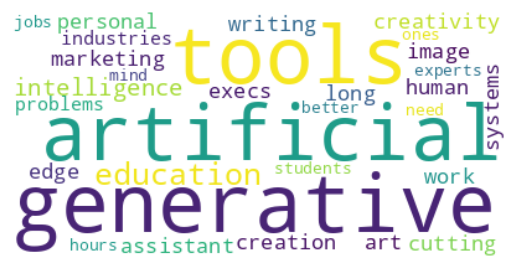

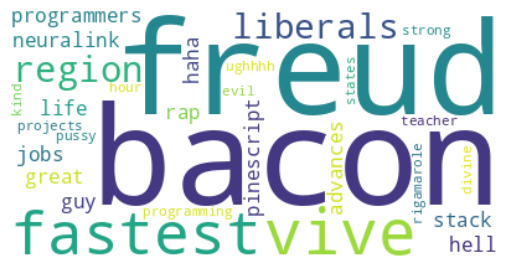

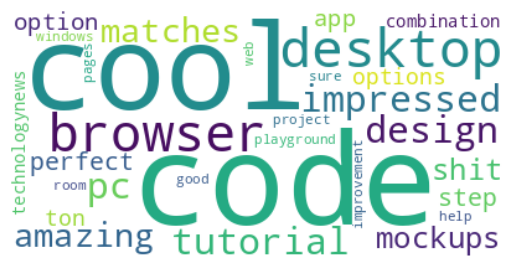

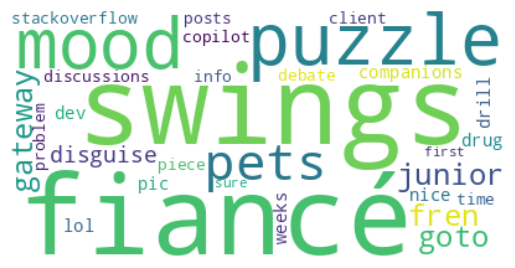

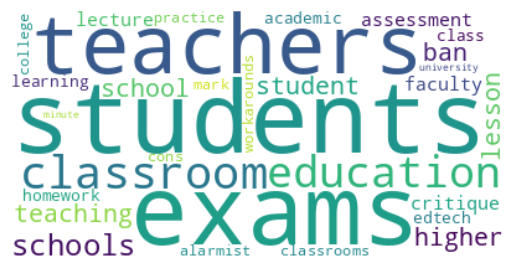

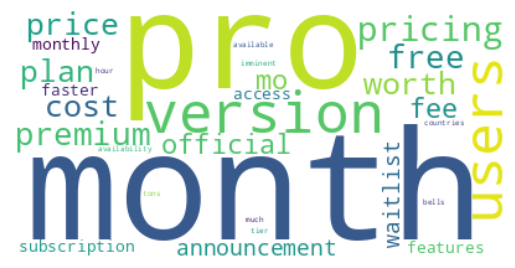

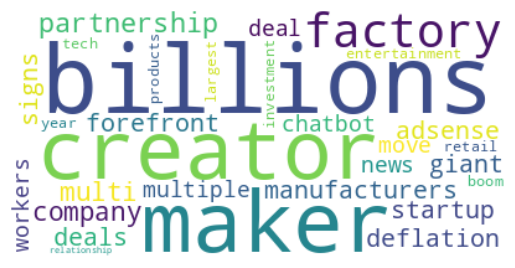

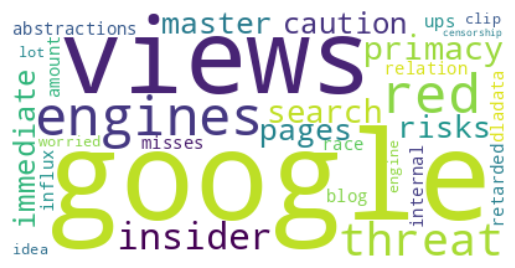

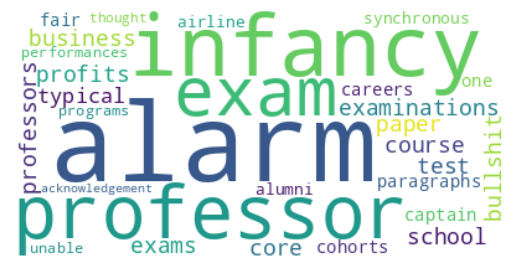

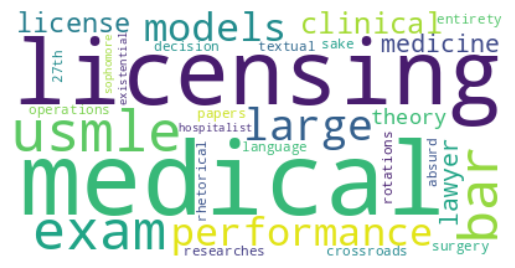

In [28]:
visualise(scores[0][2])